In [171]:
import os
import csv
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from scipy.ndimage import uniform_filter1d
from scipy.signal import butter, filtfilt

import numpy as np

import re
import pickle

from dataset import MotionDataset
from time_model import TimeModel
from tqdm.notebook import tqdm

data_path = "/home/meribejayson/Desktop/Projects/realistic-imu/data/total_capture_data"
subjects = ["s5"]

minimized_dataset = MotionDataset(data_path, subjects=subjects, dataset_type="minimized", minimize=True)
minimized_loader = DataLoader(minimized_dataset, batch_size=1, shuffle=False)

orig_dataset = MotionDataset(data_path, subjects=subjects, dataset_type="orig", minimize=False)
orig_loader = DataLoader(orig_dataset, batch_size=1, shuffle=False)

## Mean Squared Error of only applying a finite difference

In [172]:
num_exps = 0
total = 0

for mocap, imu in tqdm(orig_loader):
    diff = imu[0, :, :] - mocap[0, :, 0:26:2]
    sqr = diff ** 2

    num_exps += sqr.shape[0] * sqr.shape[1]

    total += torch.sum(sqr)

total /= num_exps
total.item()

  0%|          | 0/5 [00:00<?, ?it/s]

12.683247566223145

## Mean Squared Error with minimized accelerations

In [173]:
num_exps = 0
total = 0

for mocap, imu in tqdm(minimized_loader):
    diff = imu[0, :, :] - mocap[0, :, 0:26:2]
    sqr = diff ** 2

    num_exps += sqr.shape[0] * sqr.shape[1]

    total += torch.sum(sqr)

total /= num_exps
total.item()

  0%|          | 0/5 [00:00<?, ?it/s]

11.728960990905762

## Mean Squared error with moving average

In [174]:
num_exps = 0
total = 0

for mocap, imu in tqdm(orig_loader):
    avg_mocap = uniform_filter1d(mocap[0, :, 0:26:2].numpy(), size=11, mode='nearest', axis=0)
    diff = imu[0, :, :] - avg_mocap
    sqr = diff ** 2
    num_exps += sqr.shape[0] * sqr.shape[1]

    total += torch.sum(sqr)

total /= num_exps
total.item()

  0%|          | 0/5 [00:00<?, ?it/s]

13.127171516418457

## Mean Squared error with butterworth filter

In [175]:
def butterworth_filter(data, cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data, axis=0)

cutoff = 10
fs = 60
order = 1

num_exps = 0
total = 0

for mocap, imu in tqdm(orig_loader):
    avg_mocap = butterworth_filter(mocap[0, :, 0:26:2].numpy(), cutoff, fs, order)
    diff = imu[0, :, :] - avg_mocap
    sqr = diff ** 2
    num_exps += sqr.shape[0] * sqr.shape[1]

    total += torch.sum(sqr)

total /= num_exps
total.item()

  0%|          | 0/5 [00:00<?, ?it/s]

11.479291288241145

## Mean Squared Error of model output

In [176]:
model_path = '/home/meribejayson/Desktop/Projects/realistic-imu/models/model_3.pkl'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Using device: {device}")

# Load the model using pickle
try:
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    print("Model loaded successfully!")
except Exception as e:
    print(f"Error loading the model: {e}")

# Move the model to the GPU (if available)
model = model.to(device)
model.eval()
print(f"Model moved to: {device}")

Using device: cuda
Model loaded successfully!
Model moved to: cuda


In [177]:
for mocap, imu in tqdm(minimized_loader):
    avg_mocap = model(mocap.to(device), mocap[0, :, 0:26:2].T.to(device)).cpu().detach().numpy()
    diff = imu[0, :, :] - avg_mocap.T
    sqr = diff ** 2
    num_exps += sqr.shape[0] * sqr.shape[1]

    total += torch.sum(sqr)

total /= num_exps
total.item()

  0%|          | 0/5 [00:00<?, ?it/s]

4.6424328099634815

## Noise Bias Distribution over test dataset

In [178]:
noise_bias_values = []

NUM_OF_IMUS = 13
NUM_OF_NOISE_PARAMS = 9

def capture_noise_bias(module, input, output):
    noise_params = module.hidden_state_to_noise_params(module.norm1(input[0])).view(-1, NUM_OF_NOISE_PARAMS, NUM_OF_IMUS)  # Reconstruct noise_params
    noise_bias = noise_params[:, 8, :].T  # Extract noise_bias
    noise_bias_values.append(noise_bias.detach().cpu())

# Register the forward hook to `Noise_Regressor`
hook = model.noise_regressor.register_forward_hook(capture_noise_bias)

with torch.no_grad():
    for mocap, imu in tqdm(minimized_loader):
        avg_mocap = model(mocap.to(device), mocap[0, :, 0:26:2].T.to(device))

hook.remove()

  0%|          | 0/5 [00:00<?, ?it/s]

In [179]:
samples = torch.cat(noise_bias_values, dim=1).flatten().cpu().detach().numpy()

## What is the unconditioned distribution of the noise bias and what distribution does it look the most like
## Impossible to say without more analysis. With that said, the power spectral density is very pink, suggesting that 1/f noise or one of it higher orders might correctly describe the noise distribution
## Additionally the histogram appears to be very log normal

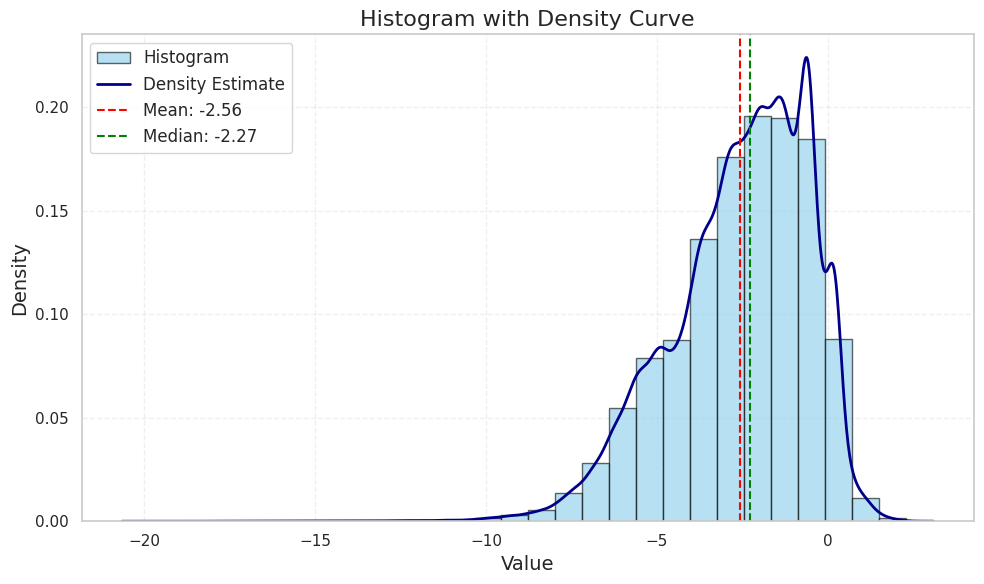

In [180]:
from scipy.stats import gaussian_kde

plt.figure(figsize=(10, 6))
counts, bins, patches = plt.hist(samples, bins=30, density=True, alpha=0.6, color='skyblue', edgecolor='black', label='Histogram')

# Add KDE (Kernel Density Estimation) for smooth density estimation
kde = gaussian_kde(samples)
x_vals = np.linspace(min(samples), max(samples), 1000)
kde_vals = kde(x_vals)
plt.plot(x_vals, kde_vals, color='darkblue', lw=2, label='Density Estimate')

# Add annotations (mean and median)
mean = np.mean(samples)
median = np.median(samples)
plt.axvline(mean, color='red', linestyle='--', linewidth=1.5, label=f'Mean: {mean:.2f}')
plt.axvline(median, color='green', linestyle='--', linewidth=1.5, label=f'Median: {median:.2f}')

# Enhance plot aesthetics
plt.title('Histogram with Density Curve', fontsize=16)
plt.xlabel('Value', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.grid(alpha=0.3, linestyle='--')
plt.legend(fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()

In [181]:
from scipy.signal import welch

# Compute Power Spectral Density (PSD) using Welch's method
fs = 60  # Sampling frequency in Hz
frequencies, psd = welch(samples, fs=fs, nperseg=2048)  # nperseg should be <= len(samples)

# Create the PSD plot
plt.figure(figsize=(10, 6))
plt.semilogy(frequencies, psd, color='darkblue', lw=2)

# Add labels, title, and grid for readability
plt.title('Power Spectral Density (PSD)', fontsize=16)
plt.xlabel('Frequency [Hz]', fontsize=14)
plt.ylabel('Power Spectral Density [V**2/Hz]', fontsize=14)
plt.grid(alpha=0.3, linestyle='--')

# Highlight the Nyquist frequency
nyquist = fs / 2
plt.axvline(nyquist, color='red', linestyle='--', linewidth=1, label=f'Nyquist: {nyquist} Hz')
plt.legend(fontsize=12)

# Enhance plot aesthetics
plt.tight_layout()

## Does anything occur when we start conditioning on the magnitude of the input embedding to the noise regressor

## It appears that at smaller magnitudes the noise bias tends to vary more and seems to vary a lot as the magnitude of the embedding vector hits 50. After this point the variance decreases

In [182]:
noise_bias_values = []
input_magnitudes = []

NUM_OF_IMUS = 13
NUM_OF_NOISE_PARAMS = 9

def capture_noise_bias(module, input, output):
    noise_params = module.hidden_state_to_noise_params(module.norm1(input[0])).view(-1, NUM_OF_NOISE_PARAMS, NUM_OF_IMUS)  # Reconstruct noise_params
    noise_bias = noise_params[:, 8, :].T  # Extract noise_bias
    noise_bias_values.append(torch.sum(noise_bias, dim=0).detach().cpu())

# Register the forward hook to `Noise_Regressor`
hook = model.noise_regressor.register_forward_hook(capture_noise_bias)

with torch.no_grad():
    for mocap, imu in tqdm(minimized_loader):
        input_magnitudes.append(torch.norm(mocap, dim=2).squeeze(0).cpu())
        avg_mocap = model(mocap.to(device), mocap[0, :, 0:26:2].T.to(device))


hook.remove()

  0%|          | 0/5 [00:00<?, ?it/s]

In [183]:
noise_bias_values[0].shape

torch.Size([3728])

In [184]:
input_magnitudes[0].shape

torch.Size([3728])

In [185]:
noise = torch.cat(noise_bias_values, dim=0).flatten().cpu().detach().numpy()
input_magnitudes = torch.cat(input_magnitudes, dim=0).flatten().cpu().detach().numpy()

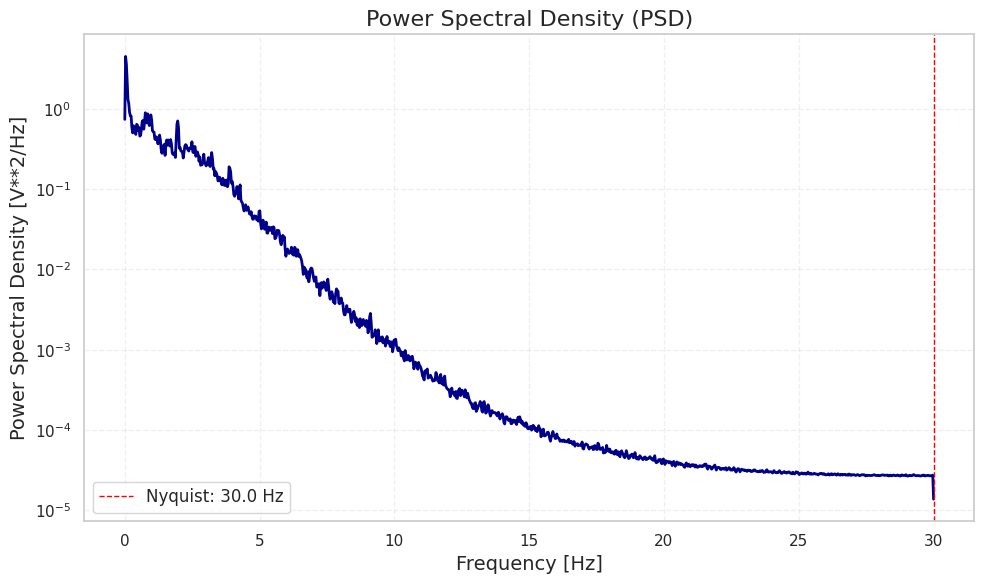

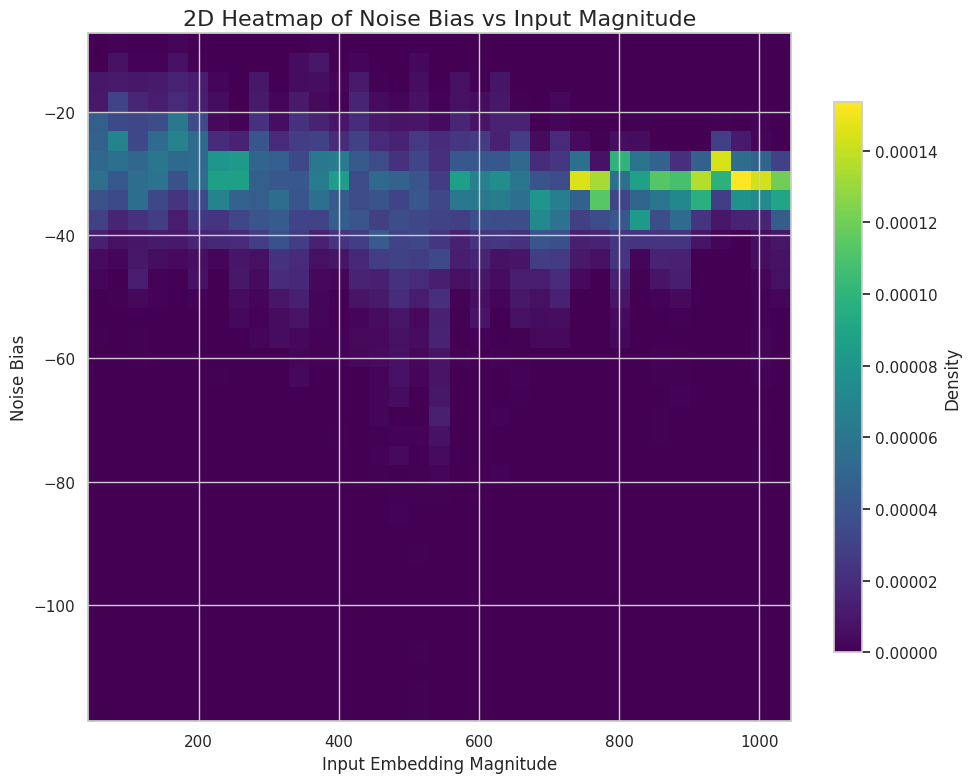

In [186]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

noise_bias_samples = noise
input_magnitudes = np.linspace(min(input_magnitudes), max(input_magnitudes), len(noise_bias_samples))

bins = 35
hist, x_edges, y_edges = np.histogram2d(input_magnitudes, noise_bias_samples, bins=bins, density=True)

x_centers = (x_edges[1:] + x_edges[:-1]) / 2
y_centers = (y_edges[1:] + y_edges[:-1]) / 2

fig, ax = plt.subplots(figsize=(10, 8))

heatmap = ax.imshow(hist.T, origin="lower", cmap="viridis",
                    extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
                    aspect="auto")

cbar = fig.colorbar(heatmap, ax=ax, shrink=0.8)
cbar.set_label('Density', fontsize=12)

ax.set_title('2D Heatmap of Noise Bias vs Input Magnitude', fontsize=16)
ax.set_xlabel('Input Embedding Magnitude', fontsize=12)
ax.set_ylabel('Noise Bias', fontsize=12)

plt.tight_layout()
plt.show()

## Is there structure to the output embedding space


In [187]:
output_emb = []

NUM_OF_IMUS = 13
NUM_OF_NOISE_PARAMS = 9

def capture_noise_bias(module, input, output):
    output_emb.append(output.detach().cpu())

# Register the forward hook to `Noise_Regressor`
hook = model.encoder.register_forward_hook(capture_noise_bias)

with torch.no_grad():
    for mocap, imu in tqdm(minimized_loader):
        model(mocap.to(device), mocap[0, :, 0:26:2].T.to(device))


hook.remove()

  0%|          | 0/5 [00:00<?, ?it/s]

In [188]:
emb = torch.cat(output_emb, dim=1).cpu().squeeze(0).detach().numpy()
emb.shape

(19086, 512)

In [189]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from matplotlib.patches import Patch
%matplotlib notebook


# Normalize data
emb = StandardScaler().fit_transform(emb)

# UMAP with adjusted parameters
reducer = umap.UMAP(n_components=2, n_neighbors=50, min_dist=0.01, random_state=42)
emb_2d = reducer.fit_transform(emb)

# Clustering to identify clusters for coloring
n_clusters = 3  # You can adjust the number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(emb_2d)

# Set plot style
sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))

# Define cluster colors
colors = sns.color_palette("tab10", n_clusters)

# Scatter plot with clusters
for cluster in range(n_clusters):
    plt.scatter(
        emb_2d[labels == cluster, 0], emb_2d[labels == cluster, 1],
        s=1, alpha=0.5, color=colors[cluster], label=f"Cluster {cluster+1}"
    )

# Add labels and title
plt.xlabel("UMAP Dimension 1", fontsize=12)
plt.ylabel("UMAP Dimension 2", fontsize=12)
plt.title("UMAP Projection of Embedding Space with Clusters", fontsize=14, fontweight="bold")

# Remove spines for a cleaner look
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# Add larger legend with colored patches
legend_elements = [Patch(facecolor=colors[i], label=f"Cluster {i+1}") for i in range(n_clusters)]
plt.legend(handles=legend_elements, fontsize=10, loc="upper right", title="Clusters", title_fontsize=12)

plt.tight_layout()
plt.savefig("embedding_umap_projection.png", dpi=300)

plt.show()



/home/meribejayson/anaconda3/envs/marker-to-ang/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


<IPython.core.display.Javascript object>

## What kind of outputs from the noise bias and the spring parameters usually output for say the imu on the foot for each cluster?

In [190]:
cluster_1_mean = emb_2d[labels == 0].mean(axis=0)

cluster_1_25_quantile = np.quantile(emb_2d[labels == 0], 0.25, axis=0)
cluster_1_75_quantile = np.quantile(emb_2d[labels == 0], 0.75, axis=0)

cluster_2_mean = emb_2d[labels == 1].mean(axis=0)

cluster_2_25_quantile = np.quantile(emb_2d[labels == 1], 0.25, axis=0)
cluster_2_75_quantile = np.quantile(emb_2d[labels == 1], 0.75, axis=0)

cluster_3_mean = emb_2d[labels == 2].mean(axis=0)

cluster_3_25_quantile = np.quantile(emb_2d[labels == 2], 0.25, axis=0)
cluster_3_75_quantile = np.quantile(emb_2d[labels == 2], 0.75, axis=0)

In [192]:
plt.scatter(cluster_1_mean[0], cluster_1_mean[1], color='red', marker='x', s=100, label="Cluster 1 Mean")
plt.scatter(cluster_1_25_quantile[0], cluster_1_25_quantile[1], color='red', marker='o', s=100, label="Cluster 1 25th Quantile")
plt.scatter(cluster_1_75_quantile[0], cluster_1_75_quantile[1], color='red', marker='o', s=100, label="Cluster 1 75th Quantile")

# Adding cluster 2 points
plt.scatter(cluster_2_mean[0], cluster_2_mean[1], color='blue', marker='x', s=100, label="Cluster 2 Mean")
plt.scatter(cluster_2_25_quantile[0], cluster_2_25_quantile[1], color='blue', marker='o', s=100, label="Cluster 2 25th Quantile")
plt.scatter(cluster_2_75_quantile[0], cluster_2_75_quantile[1], color='blue', marker='o', s=100, label="Cluster 2 75th Quantile")

# Adding cluster 3 points
plt.scatter(cluster_3_mean[0], cluster_3_mean[1], color='black', marker='x', s=100, label="Cluster 3 Mean")
plt.scatter(cluster_3_25_quantile[0], cluster_3_25_quantile[1], color='black', marker='o', s=100, label="Cluster 3 25th Quantile")
plt.scatter(cluster_3_75_quantile[0], cluster_3_75_quantile[1], color='black', marker='o', s=100, label="Cluster 3 75th Quantile")

# Update legend
plt.legend()

# Add labels and title for clarity
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Cluster Quantiles and Means")

# Refresh the plot
plt.draw()
plt.pause(1)  # Brief pause to ensure updates are visible